# Wine Types Analysis Exercise Solution

Adapted from Dipanjan Sarkar et al. 2018. [Practical Machine Learning with Python](https://link.springer.com/book/10.1007/978-1-4842-3207-1).

## Overview

This module explores predicting wine types (red vs white) using machine learning techniques. We'll use a dataset containing various chemical properties of wines to build and evaluate a classification model.

## Learning Objectives

- Learn to prepare and merge wine datasets for classification
- Build a logistic regression model to predict wine types
- Evaluate model performance using various metrics
- Interpret model results through feature importance and visualizations
- Understand how to handle binary classification problems with imbalanced classes

### Tasks to complete:

- Train logistic regression model
- Evaluate model performance metrics
- Generate and analyze feature importance
- Create ROC curve visualization
- Plot model decision surface

## Prerequisites

- Python programming environment
- Basic understanding of statistical and machine learning concepts
- Familiarity with common ML libraries


In [1]:
# Import necessary dependencies
# We wil use matplotlib and seaborn for exploratory data analysis and visualizations
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from sklearn import metrics
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

%matplotlib inline

## Load and merge datasets


In [2]:
winequality_white_data = "../../Data/winequality-white.csv"
winequality_red_data = "../../Data/winequality-red.csv"
white_wine = pd.read_csv(winequality_white_data, sep=";")
red_wine = pd.read_csv(winequality_red_data, sep=";")

# store wine type as an attribute
red_wine["wine_type"] = "red"
white_wine["wine_type"] = "white"
# bucket wine quality scores into qualitative quality labels
# Wine quality scores of 3, 4, and 5 are mapped to low quality,
# 6 and 7 are mapped to medium quality, 8 and 9 are mapped to high quality
# wines under the quality_label attribute.
red_wine["quality_label"] = red_wine["quality"].apply(
    lambda value: "low" if value <= 5 else "medium" if value <= 7 else "high"
)
red_wine["quality_label"] = pd.Categorical(
    red_wine["quality_label"], categories=["low", "medium", "high"]
)
white_wine["quality_label"] = white_wine["quality"].apply(
    lambda value: "low" if value <= 5 else "medium" if value <= 7 else "high"
)
white_wine["quality_label"] = pd.Categorical(
    white_wine["quality_label"], categories=["low", "medium", "high"]
)

# merge red and white wine datasets
wines = pd.concat([red_wine, white_wine])
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

## Understand dataset features and values


In [3]:
print(white_wine.shape, red_wine.shape)
print(wines.info())

(4898, 14) (1599, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         6497 non-null   float64 
 1   volatile acidity      6497 non-null   float64 
 2   citric acid           6497 non-null   float64 
 3   residual sugar        6497 non-null   float64 
 4   chlorides             6497 non-null   float64 
 5   free sulfur dioxide   6497 non-null   float64 
 6   total sulfur dioxide  6497 non-null   float64 
 7   density               6497 non-null   float64 
 8   pH                    6497 non-null   float64 
 9   sulphates             6497 non-null   float64 
 10  alcohol               6497 non-null   float64 
 11  quality               6497 non-null   int64   
 12  wine_type             6497 non-null   object  
 13  quality_label         6497 non-null   category
dtypes: category(1), float64(11), int64

We have 4898 white wine data points and 1599 red wine data points. The
merged dataset contains a total of 6497 data points and we also get an idea of numeric and categorical
attributes.


In [4]:
# Let’s take a peek at our dataset to see some sample data points.
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,white,high
1,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,red,low
2,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,white,medium
3,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,white,medium
4,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,white,medium


## Utilty functions for model evaluation


In [5]:
def get_metrics(true_labels, predicted_labels):
    print(
        "Accuracy:", np.round(metrics.accuracy_score(true_labels, predicted_labels), 4)
    )
    print(
        "Precision:",
        np.round(
            metrics.precision_score(true_labels, predicted_labels, average="weighted"),
            4,
        ),
    )
    print(
        "Recall:",
        np.round(
            metrics.recall_score(true_labels, predicted_labels, average="weighted"), 4
        ),
    )
    print(
        "F1 Score:",
        np.round(
            metrics.f1_score(true_labels, predicted_labels, average="weighted"), 4
        ),
    )


def display_classification_report(true_labels, predicted_labels, classes=[1, 0]):
    report = metrics.classification_report(
        y_true=true_labels, y_pred=predicted_labels, labels=classes
    )
    print(report)


def display_confusion_matrix(true_labels, predicted_labels, classes=[1, 0]):
    total_classes = len(classes)
    level_labels = [total_classes * [0], list(range(total_classes))]
    cm = metrics.confusion_matrix(
        y_true=true_labels, y_pred=predicted_labels, labels=classes
    )
    cm_frame = pd.DataFrame(
        data=cm,
        columns=pd.MultiIndex(levels=[["Predicted:"], classes], codes=level_labels),
        index=pd.MultiIndex(levels=[["Actual:"], classes], codes=level_labels),
    )
    print(cm_frame)


def display_model_performance_metrics(true_labels, predicted_labels, classes=[1, 0]):
    print("Model Performance metrics:")
    print("-" * 30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print("\nModel Classification report:")
    print("-" * 30)
    display_classification_report(
        true_labels=true_labels, predicted_labels=predicted_labels, classes=classes
    )
    print("\nPrediction Confusion Matrix:")
    print("-" * 30)
    display_confusion_matrix(
        true_labels=true_labels, predicted_labels=predicted_labels, classes=classes
    )


def plot_model_roc_curve(
    clf, features, true_labels, label_encoder=None, class_names=None
):
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, "classes_"):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError(
            "Unable to derive prediction classes, please specify class_names!"
        )
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, "predict_proba"):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1] - 1]
        elif hasattr(clf, "decision_function"):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1] - 1]
        else:
            raise AttributeError(
                "Estimator doesn't have a probability or confidence scoring system!"
            )

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            label="ROC curve (area = {0:0.2f})" "".format(roc_auc),
            linewidth=2.5,
        )

    elif n_classes > 2:
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, "decision_function"):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError(
                "Estimator doesn't have a probability or confidence scoring system!"
            )

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})"
            "".format(roc_auc["micro"]),
            linewidth=3,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})"
            "".format(roc_auc["macro"]),
            linewidth=3,
        )

        for i, label in enumerate(class_labels):
            plt.plot(
                fpr[i],
                tpr[i],
                label="ROC curve of class {0} (area = {1:0.2f})"
                "".format(label, roc_auc[i]),
                linewidth=2,
                linestyle=":",
            )
    else:
        raise ValueError("Number of classes should be atleast 2 or more")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()


def plot_model_decision_surface(
    clf,
    train_features,
    train_labels,
    plot_step=0.02,
    cmap=plt.cm.RdYlBu,
    markers=None,
    alphas=None,
    colors=None,
):
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")

    x_min, x_max = (
        train_features[:, 0].min() - plot_step,
        train_features[:, 0].max() + plot_step,
    )
    y_min, y_max = (
        train_features[:, 1].min() - plot_step,
        train_features[:, 1].max() + plot_step,
    )
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    clf_est = clone(clf)
    clf_est.fit(train_features, train_labels)
    if hasattr(clf_est, "predict_proba"):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)

    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = "".join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(
            train_features[idx, 0],
            train_features[idx, 1],
            c=color,
            label=label_names[i],
            cmap=cmap,
            edgecolors="black",
            marker=markers[i],
            alpha=alphas[i],
        )
    plt.legend()
    plt.show()

## Predicting Wine Types

We will predict the wine type based on other features. To start with, we
will first select our necessary features and separate out the prediction class labels and prepare train and test
datasets. We use the prefix **wtp\_** in our variables to easily identify them as needed, where **wtp** depicts wine
type prediction.


In [6]:
wtp_features = wines.iloc[:, :-3]
wtp_feature_names = wtp_features.columns
wtp_class_labels = np.array(wines["wine_type"])

# prepare train and test datasets

wtp_train_X, wtp_test_X, wtp_train_y, wtp_test_y = train_test_split(
    wtp_features, wtp_class_labels, test_size=0.3, random_state=42
)

print(Counter(wtp_train_y), Counter(wtp_test_y))
print("Features:", list(wtp_feature_names))

Counter({'white': 3418, 'red': 1129}) Counter({'white': 1480, 'red': 470})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


The numbers show us the wine samples for each class and we can also see the feature names which will
be used in our feature set.


## Feature Scaling

We will be using a standard scaler in this
scenario.


In [7]:
# Define the scaler
# Your code goes here
wtp_ss = StandardScaler().fit(wtp_train_X)

# Scale the train set
wtp_train_SX = wtp_ss.transform(wtp_train_X)

# Scale the test set
wtp_test_SX = wtp_ss.transform(wtp_test_X)

## Train a Model using Logistic Regression

Since we are dealing with a binary classification problem, one of the traditional Machine Learning
algorithms we can use is the logistic regression model.


### Train the model using LogisticRegression


In [8]:
wtp_lr = LogisticRegression()
wtp_lr.fit(wtp_train_SX, wtp_train_y)

LogisticRegression()

### Evaluate model performance


In [9]:
# let’s predict the wine types for our test data samples and evaluate the performance.
# Your code goes here
wtp_lr_predictions = wtp_lr.predict(wtp_test_SX)
display_model_performance_metrics(
    true_labels=wtp_test_y,
    predicted_labels=wtp_lr_predictions,
    classes=["red", "white"],
)

Model Performance metrics:
------------------------------
Accuracy: 0.9923
Precision: 0.9923
Recall: 0.9923
F1 Score: 0.9923

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         red       0.99      0.98      0.98       470
       white       0.99      1.00      0.99      1480

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     red white
Actual: red          462     8
        white          7  1473


We get an overall F1 Score and model accuracy of 99.2%! In spite of low samples of red wine, we seem to do pretty well. In case your models do not perform
well on other datasets due to a class imbalance problem, you can consider over-sampling or under-sampling
techniques including sample selection as well as SMOTE.


## Model Interpretation


### Visualize Feature Importances


[11/11] features ████████████████████ Time elapsed: 0 seconds

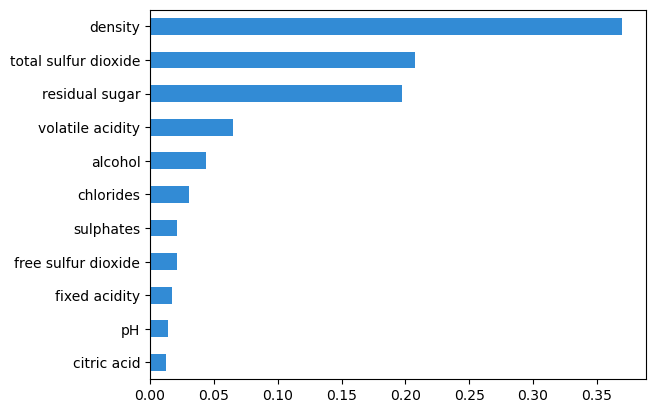

In [10]:
wtp_interpreter = Interpretation(wtp_test_SX, feature_names=wtp_features.columns)
wtp_im_model = InMemoryModel(
    wtp_lr.predict_proba, examples=wtp_train_SX, target_names=wtp_lr.classes_
)
plots = wtp_interpreter.feature_importance.plot_feature_importance(
    wtp_im_model, ascending=False
)

We can see that density, total sulfur dioxide, and residual sugar are the top three
features that contributed toward classifying wine samples as red or white


### Visualize model ROC Curve


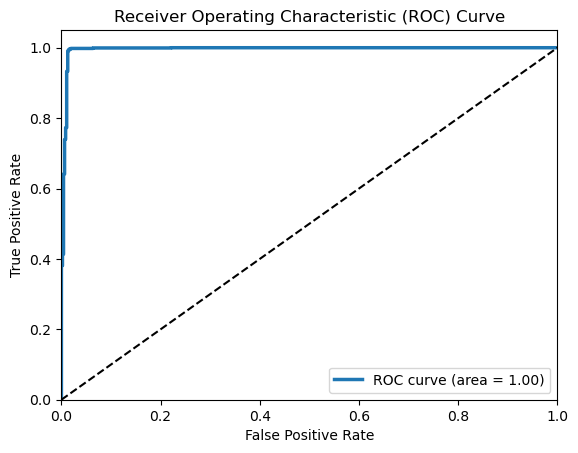

In [11]:
plot_model_roc_curve(wtp_lr, wtp_test_SX, wtp_test_y)

We achieved almost 100% accuracy if you remember for this model and hence the ROC curve is almost
perfect where we also see that the area under curve (AUC) is 1 which is perfect.


### Visualize Model Decision Surface


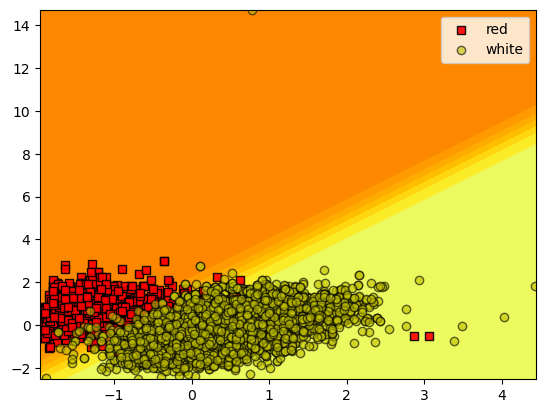

In [12]:
feature_indices = [
    i
    for i, feature in enumerate(wtp_feature_names)
    if feature in ["density", "total sulfur dioxide"]
]
plot_model_decision_surface(
    clf=wtp_lr,
    train_features=wtp_train_SX[:, feature_indices],
    train_labels=wtp_train_y,
    plot_step=0.02,
    cmap=plt.cm.Wistia_r,
    markers=[",", "o"],
    alphas=[0.9, 0.6],
    colors=["r", "y"],
)

The plot shows that our model has learned the underlying patterns
quite well based on just the two most important features, which it has used to separate out majority
of the red wine samples from the white wine samples depicted by the scatter dots. There are very few
misclassifications here and there, which are evident based on the statistics we obtained earlier in the
confusion matrices.


## Conclusion

Through this module, we learned how to:

- Successfully predict wine types using logistic regression
- Identify key features like density, total sulfur dioxide, and residual sugar that best distinguish wine types
- Evaluate model performance using metrics, ROC curves, and decision surfaces
- Handle binary classification with imbalanced classes effectively

## Clean up

Remember to:

- Save any generated plots and analysis results
- Clear notebook output if sharing
- Close dataset files
